# Analyze Region 19 - Antarctic and Subantarctic

This notebook analyzes the largest glaciers in Region 19 - Antarctic and Subantarctic

Made the decision to break up this regain into the Antartic Mainland and the Subanartic Islands. RGI contains the subantarctic islands and GLIMS contains the Antartic mainland using the outlines from Huber et al.

Huber, J., Cook, A. J., Paul, F., and Zemp, M.: A complete glacier inventory of the Antarctic Peninsula based on Landsat 7 images from 2000 to 2002 and other preexisting data sets, Earth Syst. Sci. Data, 9, 115–131, https://doi.org/10.5194/essd-9-115-2017, 2017

si = subantarctic islands

ml = mainland

In [1]:
import os
import os.path as op
import glob
import sys
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
from rasterio.plot import plotting_extent
from earthpy import clip as cl
import earthpy.plot as ep

# set working dir
HOME = op.join(op.expanduser("~"))
os.chdir(os.path.join(HOME, "git/wgms-glacier-project"))

# Set up path to load scripts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import scripts.wgms_scripts as ws

# Set Up Region Info

In [2]:
# Set region number, region name, and region index
# Once these are set, this notebook should run automatically for the specified region
region_number = "19"
region_name = "Antarctic and Subantarctic"

# The variable primeclass needs to be updated with the primary class of the ice complexes for the region
# This may need to be a list in some instances
# 2: icefield, 3: ice cap, 4: outlet glacier, 5: valley glacier, 6: mountain glacier
primeclass = 4 # This seems correct since these glaciers our outlets of the Antartic Ice Sheet

# Note for the region index, region_index_1 should be one less than the region number and 
# region_index_2 should be equal to the region number. For example, for region 1, index_1 should be set to 0 and 
# index_2 should be set to 1, etc.
region_index_1 = 18
region_index_2 = 19

# Ice cap/icefield epsg code used for calculating area
#ic_epsg = '102020'

# Show Region

In [3]:
# Open natural earth basemap TIF file
ne_fp = 'data/natural-earth/NE1_HR_LC_SR_W/NE1_HR_LC_SR_W.tif' # 10 m res
with rio.open(ne_fp) as ne_src:
    # Convert / read the data into a numpy array:
    ne_raster = ne_src.read()
    ne_src_extent = plotting_extent(ne_src)
    bounds = ne_src.bounds
    ne_raster_meta = ne_src.meta

In [4]:
# Open glacier regions
glacier_regions_fp = "data/gtn-g-glacier-regions/cleaned/GTN-G_glacier_regions_201707_cleaned.shp"
glacier_regions = gpd.read_file(glacier_regions_fp)

# Extract Region outline
region_outline = glacier_regions[region_index_1:region_index_2]

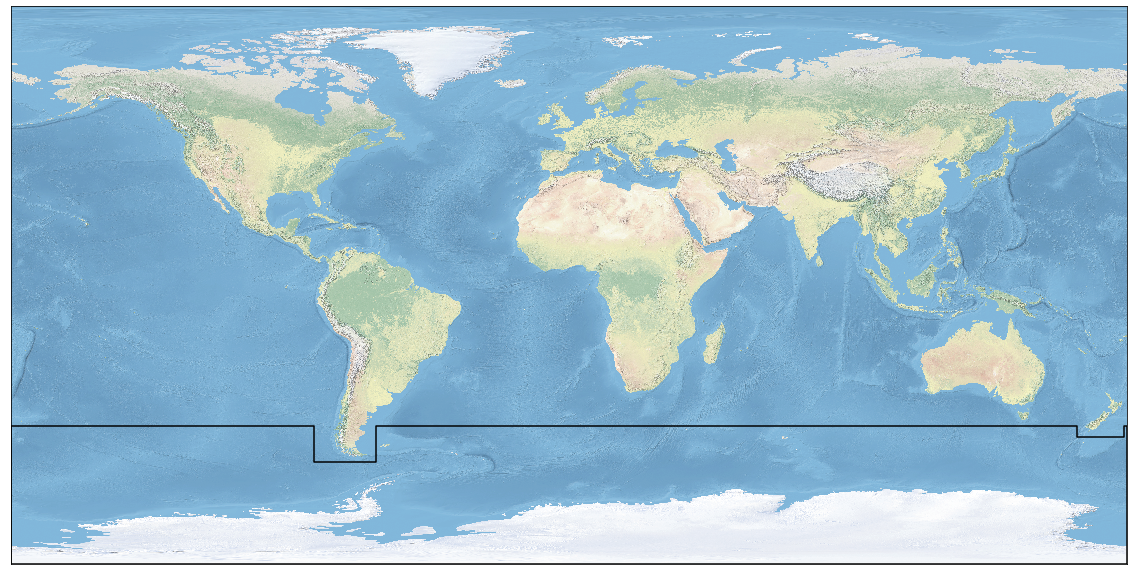

In [5]:
# Plot region outline over the natural earth
# Plot natural earth basemap
fig, ax = plt.subplots(figsize=(20, 20))

# Plot natural earth
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot region outline
region_outline.boundary.plot(ax=ax, color="black")

plt.show()

In [6]:
region_outline.bounds

minx  miny   maxx  maxy
18 -180.0 -90.0  180.0 -45.5

# * * * * * * * * Glaciers * * * * * * * *

For this region, split it into two: Antarctic Mainlan and Subantarctic Islands. The reason for this split is to separate the island glaciers from glaciers that are part of the Antarctic ice sheet. Glaciers that are part of the ice sheet are more complicated to determine if they are separate (connected) to the ice sheet or not. 

Note: RGI doesn't have the Antarctic mainland glaciers included so will use GLIMS alone for that. Because RGI only contains the Subantarctic Islands, this is an easy way to separate the mainland from the islands, so will use RGI alone for the island analysis.

## Open GLIMS 3 Largest Glaciers Data

In [7]:
# Open GLIMS three largest glacier outlines for this region.
glims_glaciers_fn = "data/glims/processed/largest/glims_region_" + region_number + "_huber_largest.shp"
glims_glaciers_df = gpd.read_file(glims_glaciers_fn)

In [8]:
# Check if GLIMS glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
glims_df_len = len(glims_glaciers_df)
for x in range(glims_df_len):
    if glims_glaciers_df['glac_name'][x] == None:
        print("GLIMS glacier " + str(x) + " equals none")
        glims_glaciers_df.loc[x, 'glac_name'] = 'NONE'

In [9]:
glims_glaciers_df

region_no         glac_id     area  db_area  width  length  primeclass  \
0         19  G294015E69537S  7018.37  7018.32    0.0     0.0         4.0   
1         19  G294357E68789S  3499.44  3499.43    0.0     0.0         4.0   
2         19  G291496E67190S  2197.84  2197.83    0.0     0.0         3.0   
3         19  G296693E69777S  2155.42  2155.43    0.0     0.0         4.0   
4         19  G295668E69137S  1816.53  1816.52    0.0     0.0         4.0   

   min_elev  mean_elev  max_elev             src_date              glac_name  \
0       4.0     1358.0    3139.0  2002-12-31T00:00:00         Seller Glacier   
1      44.0     1081.0    2006.0  2002-12-31T00:00:00  Mercator Ice Piedmont   
2       3.0      235.0     469.0  2002-12-31T00:00:00     Fuchs Ice Piedmont   
3       7.0     1330.0    3172.0  2002-12-31T00:00:00        Anthony Glacier   
4      43.0     1225.0    2127.0  2002-12-31T00:00:00          Casey Glacier   

                                            geometry  
0  POLYGON Z ((-65.065175 -69.48543600000001 0, -...  
1  POLYGON Z ((-65.083966 -68.65472800000001 0, -...  
2  POLYGON Z ((-68.914203 -67.761109 0, -68.91395...  
3  POLYGON Z ((-63.772834 -69.595417 0, -63.77214...  
4  POLYGON Z ((-63.674779 -69.032264 0, -63.67511...

## Open RGI 3 Largest Glaciers Data

In [10]:
# Open RGI three largest glacier outlines for this region.
rgi_glaciers_fn = "data/rgi/processed/largest/rgi_region_" + region_number + "_largest.shp"
rgi_glaciers_df = gpd.read_file(rgi_glaciers_fn)

In [11]:
# Check if RGI glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
rgi_df_len = len(rgi_glaciers_df)
for x in range(rgi_df_len):
    if rgi_glaciers_df['Name'][x] == None:
        print("RGI glacier " + str(x) + " equals none")
        rgi_glaciers_df.loc[x, 'Name'] = 'NONE'

RGI glacier 2 equals none
RGI glacier 3 equals none
RGI glacier 4 equals none


In [12]:
rgi_glaciers_df

RGIId         GLIMSId   BgnDate   EndDate    CenLon   CenLat  \
0  RGI60-19.01721  G238773E74044S  -9999999  -9999999 -121.2270 -74.0437   
1  RGI60-19.00423  G260838E72287S  19721204  19730130  -99.1619 -72.2868   
2  RGI60-19.00124  G289107E72447S  19970901  20011220  -70.8931 -72.4474   
3  RGI60-19.00134  G288531E71248S  19970901  20000215  -71.4686 -71.2482   
4  RGI60-19.00156  G290150E71851S  19970901  -9999999  -69.8497 -71.8512   

  O1Region O2Region      Area  Zmin  ...  Aspect    Lmax  Status  Connect  \
0       19       16  6004.845    10  ...     156   39017       0        0   
1       19       18  5260.723    10  ...      95   33233       0        0   
2       19       19  4766.142    10  ...     122   60563       0        0   
3       19       19  3980.427    10  ...     242   54549       0        0   
4       19       19  3533.646    50  ...     137  105892       0        0   

   Form  TermType  Surging  Linkages              Name  \
0     0         5        9         9  Carney Island IC   
1     0         5        9         9    Thurston I 001   
2     0         5        9         9              NONE   
3     0         5        9         9              NONE   
4     1         5        9         9              NONE   

                                            geometry  
0  POLYGON ((-123.196889617 -73.88773663899997, -...  
1  POLYGON ((-100.71160608 -71.95814650899996, -1...  
2  POLYGON ((-69.10762573799997 -72.1447113459999...  
3  POLYGON ((-70.62503227599996 -70.9788515899999...  
4  POLYGON ((-70.31912156899995 -71.3438353009999...  

[5 rows x 23 columns]

## Plot GLIMS Glaciers

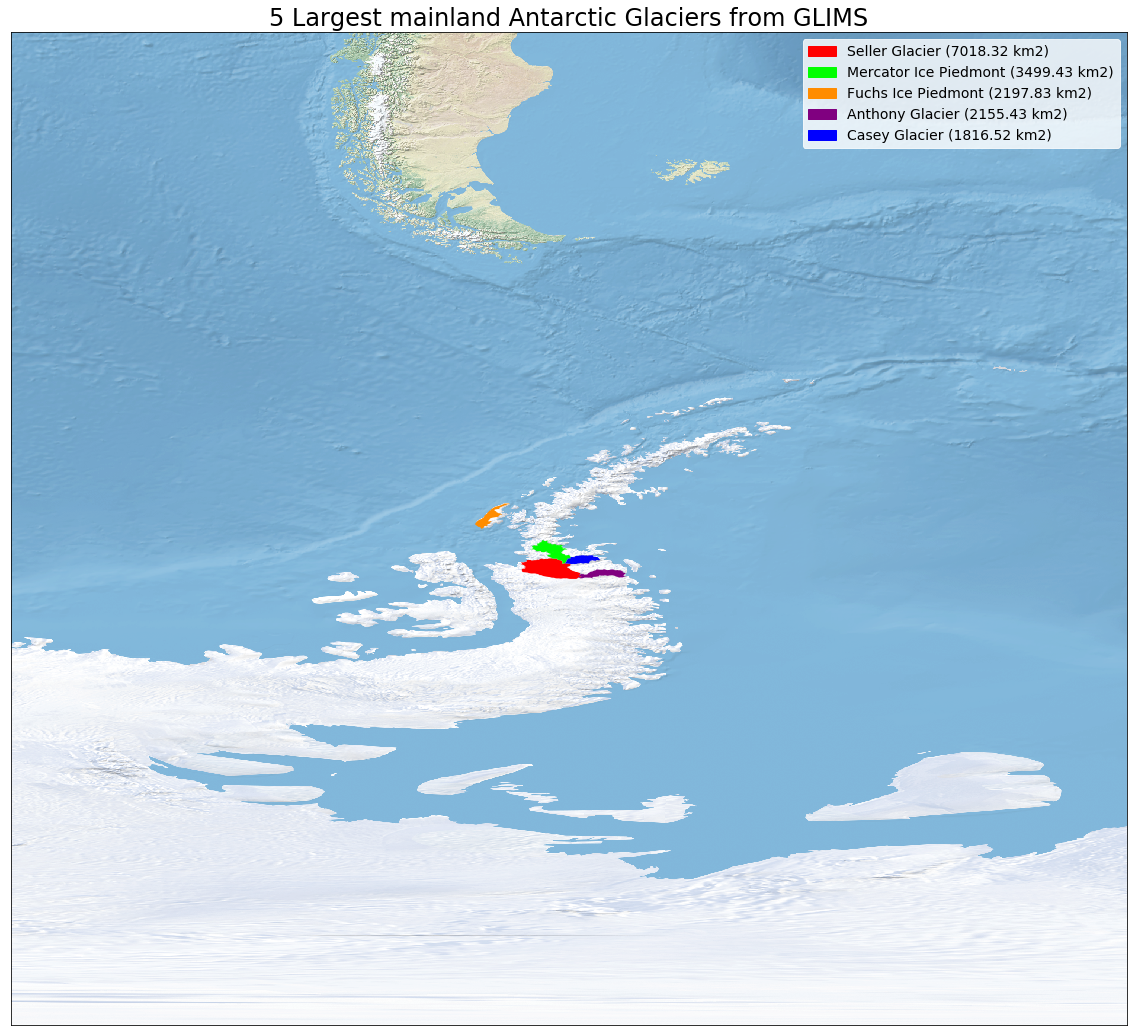

In [13]:
# Plot 3 largest glaciers on natural earth from GLIMS
legend_colors = ['red', 'lime', 'darkorange', 'purple', 'blue']
legend_labels = [glims_glaciers_df['glac_name'][0] + ' (' + str(glims_glaciers_df['db_area'][0]) + ' km2)',
                 glims_glaciers_df['glac_name'][1] + ' (' + str(glims_glaciers_df['db_area'][1]) + ' km2)',
                 glims_glaciers_df['glac_name'][2] + ' (' + str(glims_glaciers_df['db_area'][2]) + ' km2)',
                 glims_glaciers_df['glac_name'][3] + ' (' + str(glims_glaciers_df['db_area'][3]) + ' km2)',
                 glims_glaciers_df['glac_name'][4] + ' (' + str(glims_glaciers_df['db_area'][4]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
maxx = -40
minx = -90
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
glims_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
glims_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
glims_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
glims_glaciers_df.iloc[3:4].plot(ax=ax, color='purple')
glims_glaciers_df.iloc[4:5].plot(ax=ax, color='blue')
ax.set_title('5 Largest mainland Antarctic Glaciers from GLIMS', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

## Plot RGI Glaciers

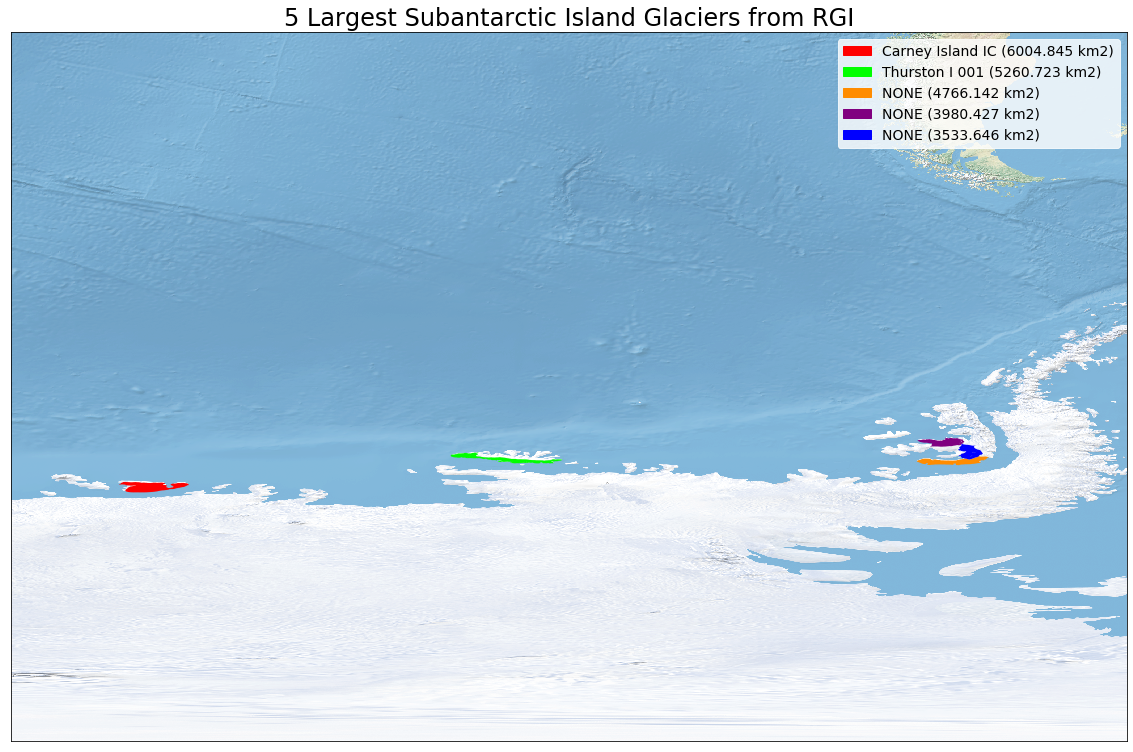

In [14]:
# Plot 3 largest glaciers on natural earth from RGI
legend_colors = ['red', 'lime', 'darkorange', 'purple', 'blue']
legend_labels = [rgi_glaciers_df['Name'][0] + ' (' + str(rgi_glaciers_df['Area'][0]) + ' km2)',
                 rgi_glaciers_df['Name'][1] + ' (' + str(rgi_glaciers_df['Area'][1]) + ' km2)',
                 rgi_glaciers_df['Name'][2] + ' (' + str(rgi_glaciers_df['Area'][2]) + ' km2)',
                 rgi_glaciers_df['Name'][3] + ' (' + str(rgi_glaciers_df['Area'][3]) + ' km2)',
                 rgi_glaciers_df['Name'][4] + ' (' + str(rgi_glaciers_df['Area'][4]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
maxx = -60
minx = -130
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from rgi dataframe
rgi_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
rgi_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
rgi_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
rgi_glaciers_df.iloc[3:4].plot(ax=ax, color='purple')
rgi_glaciers_df.iloc[4:5].plot(ax=ax, color='blue')
ax.set_title('5 Largest Subantarctic Island Glaciers from RGI', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

## Antarctic Mainland Glaciers
Use GLIMS for these. The three largest are (excluding Fuchs Ice Piedmont because it is part of the subanarctic islands).
1. Seller Glacier 7018.32
1. Mercator Ice Piedmont 3499.43 (need to check with Michael if I should exclude this because it is an ice piedmont)
1. Anthony Glacier 2155.43

## Create final shapefiles
This section creates and formats the final dataframe, plots it to make sure it looks ok, and saves it to a shapefile.


### Create final dataframe

In [15]:
# Set up the final dataframe that will be used when saving the final shapefiles
# Drop columns that are not needed for the final data (use GLIMS dataframe for this)
final_data_ml_df = glims_glaciers_df.drop(['area', 'width', 'length', 
                                        'min_elev', 'mean_elev', 'max_elev'], axis=1)

# Add region_name column
final_data_ml_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_data_ml_df['primeclass'] = primeclass

# Rename some columns
final_data_ml_df.rename(columns={'glac_id': 'glims_id', 'db_area': 'area_km2', 
                                       'src_date': 'date'}, inplace=True)

# Drop row 3 because it is not on the Antarctic peninsula and drop row 5 because it isn't in the top 3 and reset index
final_data_ml_df.drop([2, 4], inplace = True)
final_data_ml_df.reset_index(drop=True, inplace=True)

# Add RGI ID column
final_data_ml_df['rgi_id'] = 'N/A'

# Add area_src column that gets filled lower down
final_data_ml_df['area_src'] = 'G'

# Reorder the columns of the dataframe
final_data_ml_df = final_data_ml_df[['region_no', 'reg_name', 'glac_name', 'glims_id', 'rgi_id', 
                                     'primeclass', 'area_km2', 'area_src', 'date', 'geometry']]

In [16]:
final_data_ml_df

region_no                    reg_name              glac_name  \
0         19  Antarctic and Subantarctic         Seller Glacier   
1         19  Antarctic and Subantarctic  Mercator Ice Piedmont   
2         19  Antarctic and Subantarctic        Anthony Glacier   

         glims_id rgi_id  primeclass  area_km2 area_src                 date  \
0  G294015E69537S    N/A           4   7018.32        G  2002-12-31T00:00:00   
1  G294357E68789S    N/A           4   3499.43        G  2002-12-31T00:00:00   
2  G296693E69777S    N/A           4   2155.43        G  2002-12-31T00:00:00   

                                            geometry  
0  POLYGON Z ((-65.065175 -69.48543600000001 0, -...  
1  POLYGON Z ((-65.083966 -68.65472800000001 0, -...  
2  POLYGON Z ((-63.772834 -69.595417 0, -63.77214...

In [17]:
# Clean the date format in the final dataframe
final_data_ml_df['date'] = final_data_ml_df['date'].str[:10]

In [18]:
final_data_ml_df

region_no                    reg_name              glac_name  \
0         19  Antarctic and Subantarctic         Seller Glacier   
1         19  Antarctic and Subantarctic  Mercator Ice Piedmont   
2         19  Antarctic and Subantarctic        Anthony Glacier   

         glims_id rgi_id  primeclass  area_km2 area_src        date  \
0  G294015E69537S    N/A           4   7018.32        G  2002-12-31   
1  G294357E68789S    N/A           4   3499.43        G  2002-12-31   
2  G296693E69777S    N/A           4   2155.43        G  2002-12-31   

                                            geometry  
0  POLYGON Z ((-65.065175 -69.48543600000001 0, -...  
1  POLYGON Z ((-65.083966 -68.65472800000001 0, -...  
2  POLYGON Z ((-63.772834 -69.595417 0, -63.77214...

### Plot final dataframe to check accuracy

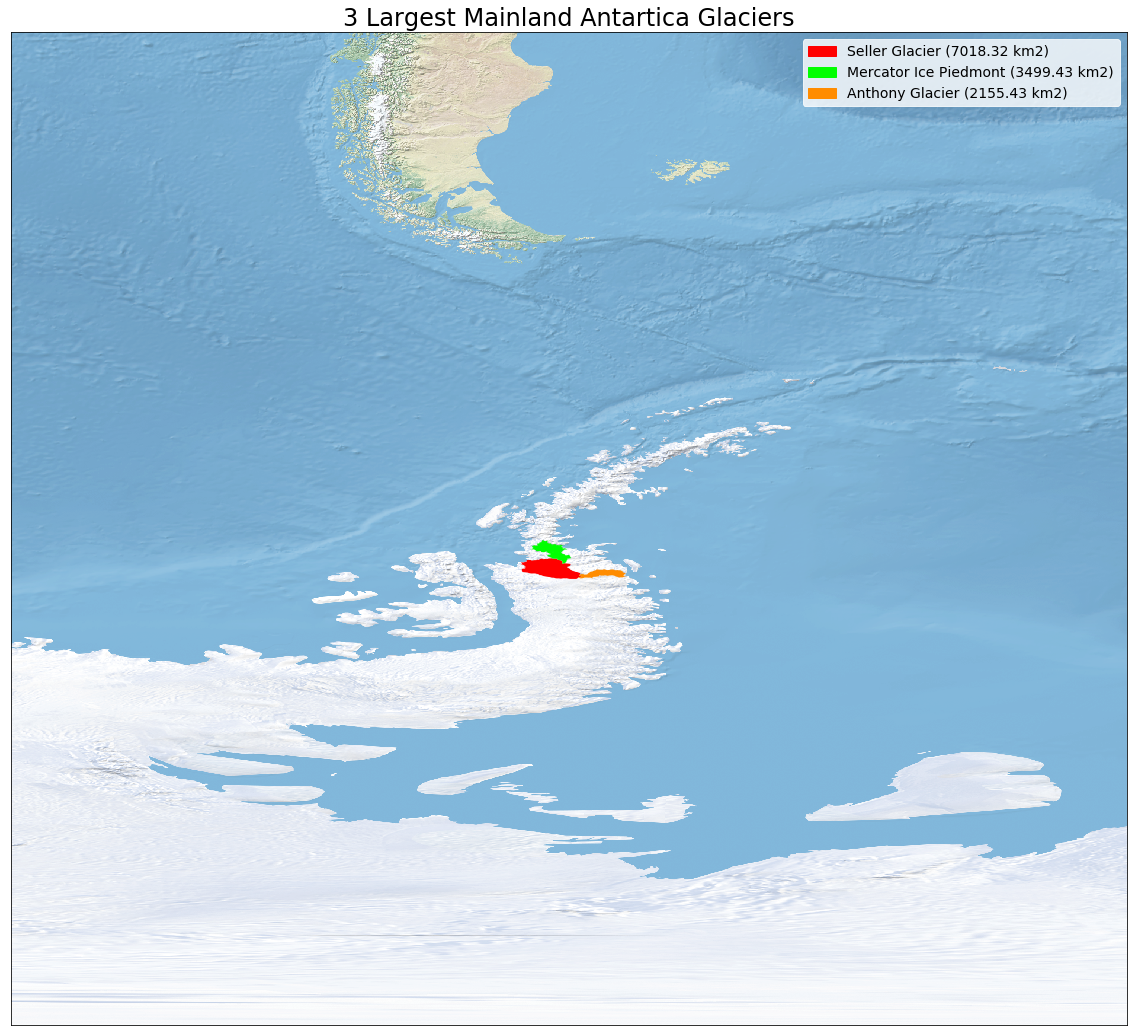

In [19]:
# Check that the geodataframe wasn't corrupted from these changes by plotting the data
# Plot 3 largest glaciers on natural earth from GLIMS
# Set up legend. Note that the sizes come from an average of GLIMS and RGI. 
# See wgms-glacier-project/data/comparison/compare-glims-rgi.xlsx
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [final_data_ml_df['glac_name'][0] + ' (' + str(round(final_data_ml_df['area_km2'][0], 2)) + ' km2)',
                 final_data_ml_df['glac_name'][1] + ' (' + str(round(final_data_ml_df['area_km2'][1], 2)) + ' km2)',
                 final_data_ml_df['glac_name'][2] + ' (' + str(round(final_data_ml_df['area_km2'][2], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
maxx = -40
minx = -90
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
final_data_ml_df.iloc[0:1].plot(ax=ax, color='red')
final_data_ml_df.iloc[1:2].plot(ax=ax, color='lime')
final_data_ml_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest Mainland Antartica Glaciers', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

### Create shapefile from the final dataframe

In [20]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
zipfile_ml_fn = "data/final-dataset/region-" + region_number + "-mainland-largest-glaciers.zip"
if os.path.exists(zipfile_ml_fn) == False:
    # Create the shapefile
    final_data_ml_fn = "data/final-dataset/region-" + region_number + "-mainland-largest-glaciers.shp"
    final_data_ml_df.to_file(driver='ESRI Shapefile', filename=final_data_ml_fn)
    
    # Zip up the shapefile
    zipfile_ml_fn = ws.zipshp(final_data_ml_fn, Delete=True)
    print("Creating zipfile: " + zipfile_ml_fn)
else:
    print(zipfile_ml_fn + " already extists")

data/final-dataset/region-19-mainland-largest-glaciers.zip already extists


## Subantartic Islands Glaciers
Use RGI for these. 

The first one in RGi is an ice cap (Carney Island Ice Cap).

The second is a glacier (Thurston Island 001 Glacier).

The third is an ice cap according to Bliss, Hock, and Cogley (2013), however, just because this paper lists it as an ice cap doesn't necessarily mean that is what others will think. Going to consider it for the largest glaciers, also this makes it easier from an automatic processing point of view.

The fourth is a glacier on Alexander Island according to Bliss, Hock, and Cogley (2013).

The fifth is a glacier on Alexander Island Bliss, Hock, and Cogley (2013).

The 3 largest are the following:

1. Thurston Island Glacier 001 5260.723 km2 (RGI60-19.00423, G260838E72287S)
1. Unnamed Glacier on Alexander Island 4766.1 km2 (named this Alexander Island Glacier No. 1) (RGI60-19.00124, G289107E72447S)
1. Unnamed Glacier on Alexander Island 3980.4 km2 (named this Alexander Island Glacier No. 2) (RGI60-19.00134, G288531E71248S)
1. Unnamed Glacier on Alexander Island 3533.6 km2 (listing the 4th one just in case we decide that the 2nd largest is an ice cap) (RGI60-19.00156, G290150E71851S)

## Create final shapefiles
This section creates and formats the final dataframe, plots it to make sure it looks ok, and saves it to a shapefile.

### Create final dataframe

In [27]:
# Set up the final dataframe that will be used when saving the final shapefiles
# Drop columns that are not needed for the final data (use RGI dataframe for this)
final_data_si_df = rgi_glaciers_df.drop(['CenLon', 'CenLat', 'O2Region', 'EndDate',
                                        'Zmin', 'Zmax', 'Zmed', 'Slope', 'Aspect', 'Lmax', 'Status',
                                         'Connect', 'Form', 'TermType', 'Surging', 'Linkages'], axis=1)

# Add region_name column
final_data_si_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_data_si_df['primeclass'] = primeclass

# Rename some columns
final_data_si_df.rename(columns={'O1Region': 'region_no', 'GLIMSId': 'glims_id', 'Area': 'area_km2', 
                                 'BgnDate': 'date', 'Name': 'glac_name', 'RGIId': 'rgi_id'}, inplace=True)

# Drop the 1st because it is an ice caps and will be analyzed in the ice cap section and drop the last since it 
# doesn't make the top 3, also reset index
final_data_si_df.drop([0, 4], inplace = True)
final_data_si_df.reset_index(drop=True, inplace=True)

# Clean up glacier names
final_data_si_df.iloc[0, final_data_si_df.columns.get_loc('glac_name')] = "Thurston Island Glacier No. 1"
final_data_si_df.iloc[1, final_data_si_df.columns.get_loc('glac_name')] = "Alexander Island Glacier No. 1"
final_data_si_df.iloc[2, final_data_si_df.columns.get_loc('glac_name')] = "Alexander Island Glacier No. 2"

# Format dates
d0 = final_data_si_df.iloc[0, final_data_si_df.columns.get_loc('date')]
d0 = '-'.join([d0[:4], d0[4:6], d0[6:]]) # add hyphens
final_data_si_df.iloc[0, final_data_si_df.columns.get_loc('date')] = d0

d1 = final_data_si_df.iloc[1, final_data_si_df.columns.get_loc('date')]
d1 = '-'.join([d1[:4], d1[4:6], d1[6:]]) # add hyphens
final_data_si_df.iloc[1, final_data_si_df.columns.get_loc('date')] = d1

d2 = final_data_si_df.iloc[2, final_data_si_df.columns.get_loc('date')]
d2 = '-'.join([d2[:4], d2[4:6], d2[6:]])
final_data_si_df.iloc[2, final_data_si_df.columns.get_loc('date')] = d2

# Add area_src column that gets filled lower down
final_data_si_df['area_src'] = 'R'

# Reorder the columns of the dataframe
final_data_si_df = final_data_si_df[['region_no', 'reg_name', 'glac_name', 'glims_id', 'rgi_id', 
                                     'primeclass', 'area_km2', 'area_src', 'date', 'geometry']]

# Because only using the RGI data only, set the GLIMS ID to N/A because te RGI database glims ids don't match 
# the way the GLIMS database does it.
final_data_si_df['glims_id'] = 'N/A'

In [28]:
final_data_si_df

region_no                    reg_name                       glac_name  \
0        19  Antarctic and Subantarctic   Thurston Island Glacier No. 1   
1        19  Antarctic and Subantarctic  Alexander Island Glacier No. 1   
2        19  Antarctic and Subantarctic  Alexander Island Glacier No. 2   

  glims_id          rgi_id  primeclass  area_km2 area_src        date  \
0      N/A  RGI60-19.00423           4  5260.723        R  1972-12-04   
1      N/A  RGI60-19.00124           4  4766.142        R  1997-09-01   
2      N/A  RGI60-19.00134           4  3980.427        R  1997-09-01   

                                            geometry  
0  POLYGON ((-100.71160608 -71.95814650899996, -1...  
1  POLYGON ((-69.10762573799997 -72.1447113459999...  
2  POLYGON ((-70.62503227599996 -70.9788515899999...

### Plot final dataframe to check accuracy

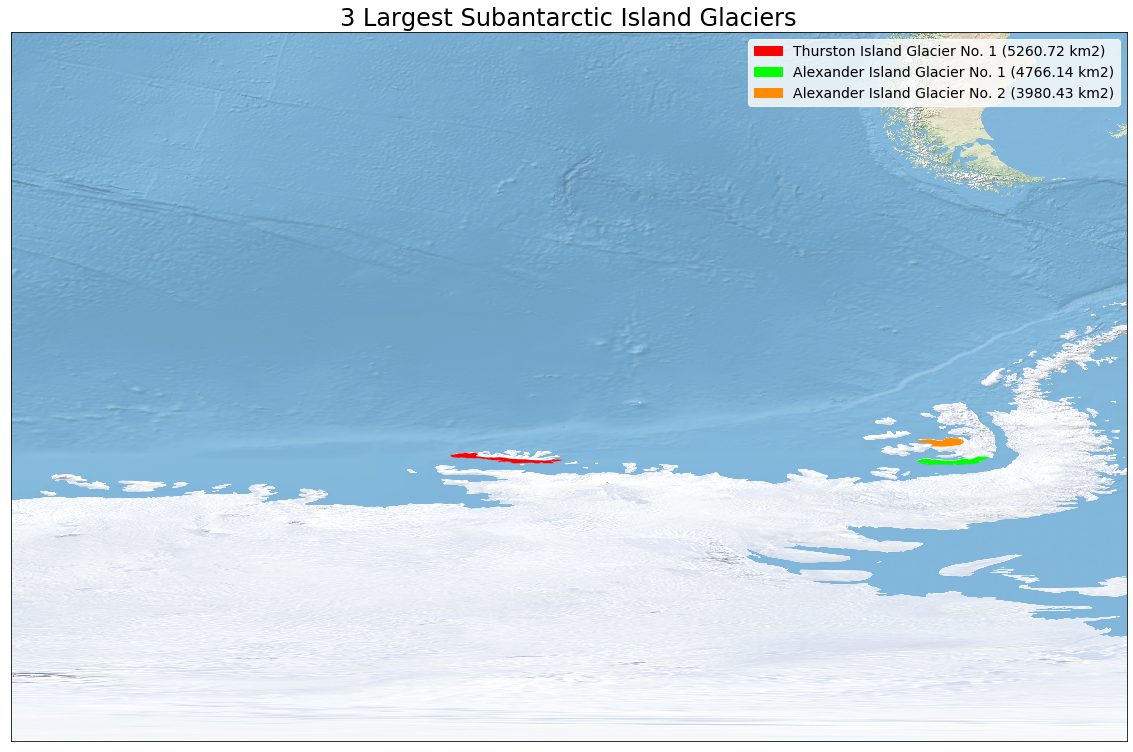

In [29]:
# Check that the geodataframe wasn't corrupted from these changes by plotting the data
# Plot 3 largest glaciers on natural earth from GLIMS
# Set up legend. Note that the sizes come from an average of GLIMS and RGI. 
# See wgms-glacier-project/data/comparison/compare-glims-rgi.xlsx
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [final_data_si_df['glac_name'][0] + ' (' + str(round(final_data_si_df['area_km2'][0], 2)) + ' km2)',
                 final_data_si_df['glac_name'][1] + ' (' + str(round(final_data_si_df['area_km2'][1], 2)) + ' km2)',
                 final_data_si_df['glac_name'][2] + ' (' + str(round(final_data_si_df['area_km2'][2], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
maxx = -60
minx = -130
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
final_data_si_df.iloc[0:1].plot(ax=ax, color='red')
final_data_si_df.iloc[1:2].plot(ax=ax, color='lime')
final_data_si_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest Subantarctic Island Glaciers', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

### Create shapefile from the final dataframe

In [30]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
zipfile_si_fn = "data/final-dataset/region-" + region_number + "-islands-largest-glaciers.zip"
if os.path.exists(zipfile_si_fn) == False:
    # Create the shapefile
    final_data_si_fn = "data/final-dataset/region-" + region_number + "-islands-largest-glaciers.shp"
    final_data_si_df.to_file(driver='ESRI Shapefile', filename=final_data_si_fn)
    
    # Zip up the shapefile
    zipfile_si_fn = ws.zipshp(final_data_si_fn, Delete=True)
    print("Creating zipfile: " + zipfile_si_fn)
else:
    print(zipfile_si_fn + " already extists")

Creating zipfile: data/final-dataset\region-19-islands-largest-glaciers.zip


# * * * * * * * * Ice Cap Analysis * * * * * * * *

This is done for the subantarctic islands with RGI data. I do not do a separate ice cap analysis for the mainland, instead determine the full extent of the glacier complex on the Antarctic Pensula with GLIMS Huber data.

### Subantarctic Islands Ice Caps

It looks like the top 3 subantarctic island ice caps are:

1. Alexander Island Unnamed Ice Cap
2. Thurston Island Ice Cap
3. Carney Island Ice Cap

In [ ]:
# Open this regions ice caps from the exploded version
ice_caps_ex_fn = "data/rgi/processed/ice-caps/largest/largest-ice-caps-region_" + region_number + "_islands_laea.shp"
ice_caps_ex_df = gpd.read_file(ice_caps_ex_fn)

In [ ]:
ice_caps_ex_df

In [ ]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['darkorange', 'red', 'blue', 'purple', 'pink', 'yellow', 'green', 'cyan', 'magenta', 'lime']
legend_labels = ['Alexander Island (id ' + str(ice_caps_ex_df['id'][0]) + ')',
                 'Thurston Island Ice Cap (id ' + str(ice_caps_ex_df['id'][1]) + ')', 
                 'Carney Island Ice Cap (id ' + str(ice_caps_ex_df['id'][2]) + ')', 
                 'Siple Island Ice Cap (id ' + str(ice_caps_ex_df['id'][3]) + ')',
                 'Adelaide Island Ice Cap (id ' + str(ice_caps_ex_df['id'][4]) + ')',
                 'Rothschild Island Ice Cap (id ' + str(ice_caps_ex_df['id'][5]) + ')', 
                 'Smyley Island Ice Cap (id )' + str(ice_caps_ex_df['id'][6]) + ')', 
                 'Unknown (3346)', 'Unknown (1904)', 'Unknown (3343)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
maxx = -60
minx = -130
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
ice_caps_ex_df.iloc[0:1].plot(ax=ax, color="darkorange")
ice_caps_ex_df.iloc[1:2].plot(ax=ax, color="red")
ice_caps_ex_df.iloc[2:3].plot(ax=ax, color="blue")
ice_caps_ex_df.iloc[3:4].plot(ax=ax, color="purple")
ice_caps_ex_df.iloc[4:5].plot(ax=ax, color="pink")
ice_caps_ex_df.iloc[5:6].plot(ax=ax, color="yellow")
ice_caps_ex_df.iloc[6:7].plot(ax=ax, color="green")
ice_caps_ex_df.iloc[7:8].plot(ax=ax, color="cyan")
ice_caps_ex_df.iloc[8:9].plot(ax=ax, color="magenta")
ice_caps_ex_df.iloc[9:10].plot(ax=ax, color="lime")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

### Create Final Ice Catchment Data Frame

This ice catchment data frame will then be saved to a shapefile.

In [ ]:
# Update and reorganize ice_caps_ex_df to create final df
# Drop uneeded columns
final_catchment_data_df = ice_caps_ex_df.drop(['id'], axis=1)

# Drop last 7 rows because only interested in the top 3 ice caps/icefields
final_catchment_data_df.drop([3, 4, 5, 6, 7, 8, 9], inplace = True)

# Add region_no column
final_catchment_data_df['region_no'] = region_number

# Add region_name column
final_catchment_data_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_catchment_data_df['primeclass'] = [2, 3, 3]

# Add catchment names
final_catchment_data_df['ic_name'] = ['Alexander Island Glacier Complex', 
                                      'Thurston Island Ice Cap', 
                                      'Carney Island Ice Cap']

### Get ice catchment GLIMS IDs and measurement dates from a range of glacier outline dates.

In [ ]:
# Open RGI shapefile with all of the glacier outlines
rgi_all_glaciers_df = ws.open_rgi_region(int(region_number))

In [ ]:
# The call to the pip function can take a couple of minutes to many hours to run depending on the complexity and size
# of the ice catchment outline. I set up the code to save the output to shapefiles that can be read in more quickly
# if desired. However, you can toggle whether you read the files or run the pip command with the following variable.
# Note that you must run the pip command the first time this code is run in order to create the shapefiles.
run_code = 0 # set to 0 to read from shapefiles, set to 1 to run pip command

# Get glaciers in the 1st largest glacier complex
if run_code == 1: # run pip command
    largest_ic_1_mask = ws.pip(rgi_all_glaciers_df, ice_caps_ex_df.iloc[0:1].reset_index(drop=True))
    largest_ic_1_glaciers = rgi_all_glaciers_df.loc[largest_ic_1_mask]
    largest_ic_1_glaciers.reset_index(drop=True, inplace=True)
elif run_code == 0: # read saved shapefiles
    ic_1_glaciers_zfn = "data/rgi/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                        region_number + "-islands-1st-largest-ic-glacier-outlines.zip"
    with zipfile.ZipFile(ic_1_glaciers_zfn,"r") as zip_ref:
        zip_ref.extractall("data/rgi/processed/ice-caps/largest/individual-glacier-outlines/unzipped")

    ic_1_glaciers_shape_fn = "data/rgi/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-" + \
                                  region_number + "-islands-1st-largest-ic-glacier-outlines.shp"
    largest_ic_1_glaciers = gpd.read_file(ic_1_glaciers_shape_fn)
    print("Reading file " + ic_1_glaciers_shape_fn)

    # Clean up unzipped files to save disk space
    filelist = glob.glob("data/rgi/processed/ice-caps/largest/individual-glacier-outlines/unzipped/*")
    for f in filelist:
        os.remove(f)
else:
    print("Incorrect value for the run_code variable. Must be 0 or 1.")

# Clean and print the minimum date and the maximum date
largest_ic_1_min_date = largest_ic_1_glaciers['BgnDate'].min()
largest_ic_1_max_date = largest_ic_1_glaciers['BgnDate'].max()
# Format date to YYYY-MM-DD
largest_ic_1_min_date = largest_ic_1_min_date[0:4] + '-' + largest_ic_1_min_date[4:6] + '-' + \
                        largest_ic_1_min_date[6:8]
largest_ic_1_max_date = largest_ic_1_max_date[0:4] + '-' + largest_ic_1_max_date[4:6] + '-' + \
                        largest_ic_1_max_date[6:8]
print('1st largest start date: ' + largest_ic_1_min_date)
print('1st largest end date: ' + largest_ic_1_max_date)
print('')

# Get all rgi and glims ids that make up the 1st largest ice catchment
largest_ic_1_rgi_ids = largest_ic_1_glaciers['RGIId']
largest_ic_1_glims_ids = largest_ic_1_glaciers['GLIMSId']
for i in range(len(largest_ic_1_glims_ids)):
    if i == 0:
        all_largest_ic_1_rgi_ids = largest_ic_1_rgi_ids[i]
        all_largest_ic_1_glims_ids = largest_ic_1_glims_ids[i]
    else:
        all_largest_ic_1_rgi_ids = all_largest_ic_1_rgi_ids + ', ' + largest_ic_1_rgi_ids[i]
        all_largest_ic_1_glims_ids = all_largest_ic_1_glims_ids + ', ' + largest_ic_1_glims_ids[i]

# Get glaciers in the 2nd largest glacier complex
if run_code == 1: # run pip command
    largest_ic_2_mask = ws.pip(rgi_all_glaciers_df, ice_caps_ex_df.iloc[1:2].reset_index(drop=True))
    largest_ic_2_glaciers = rgi_all_glaciers_df.loc[largest_ic_2_mask]
    largest_ic_2_glaciers.reset_index(drop=True, inplace=True)
elif run_code == 0: # read saved shapefiles
    ic_2_glaciers_zfn = "data/rgi/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                        region_number + "-islands-2nd-largest-ic-glacier-outlines.zip"
    with zipfile.ZipFile(ic_2_glaciers_zfn,"r") as zip_ref:
        zip_ref.extractall("data/rgi/processed/ice-caps/largest/individual-glacier-outlines/unzipped")

    ic_2_glaciers_shape_fn = "data/rgi/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-" + \
                                  region_number + "-islands-2nd-largest-ic-glacier-outlines.shp"
    largest_ic_2_glaciers = gpd.read_file(ic_2_glaciers_shape_fn)
    print("Reading file " + ic_2_glaciers_shape_fn)

    # Clean up unzipped files to save disk space
    filelist = glob.glob("data/rgi/processed/ice-caps/largest/individual-glacier-outlines/unzipped/*")
    for f in filelist:
        os.remove(f)
else:
    print("Incorrect value for the run_code variable. Must be 0 or 1.")

# Clean and print the minimum date and the maximum date
largest_ic_2_min_date = largest_ic_2_glaciers['BgnDate'].min()
largest_ic_2_max_date = largest_ic_2_glaciers['BgnDate'].max()
# Format date to YYYY-MM-DD
largest_ic_2_min_date = largest_ic_2_min_date[0:4] + '-' + largest_ic_2_min_date[4:6] + '-' + \
                        largest_ic_2_min_date[6:8]
largest_ic_2_max_date = largest_ic_2_max_date[0:4] + '-' + largest_ic_2_max_date[4:6] + '-' + \
                        largest_ic_2_max_date[6:8]
print('2nd largest start date: ' + largest_ic_2_min_date)
print('2nd largest end date: ' + largest_ic_2_max_date)
print('')

# Get all rgi and glims ids that make up the 2nd largest ice catchment
largest_ic_2_rgi_ids = largest_ic_2_glaciers['RGIId']
largest_ic_2_glims_ids = largest_ic_2_glaciers['GLIMSId']
for i in range(len(largest_ic_2_glims_ids)):
    if i == 0:
        all_largest_ic_2_rgi_ids = largest_ic_2_rgi_ids[i]
        all_largest_ic_2_glims_ids = largest_ic_2_glims_ids[i]
    else:
        all_largest_ic_2_rgi_ids = all_largest_ic_2_rgi_ids + ', ' + largest_ic_2_rgi_ids[i]
        all_largest_ic_2_glims_ids = all_largest_ic_2_glims_ids + ', ' + largest_ic_2_glims_ids[i]


# Get glaciers in the 3rd largest glacier complex
if run_code == 1: # run pip command
    largest_ic_3_mask = ws.pip(rgi_all_glaciers_df, ice_caps_ex_df.iloc[2:3].reset_index(drop=True))
    largest_ic_3_glaciers = rgi_all_glaciers_df.loc[largest_ic_3_mask]
    largest_ic_3_glaciers.reset_index(drop=True, inplace=True)
elif run_code == 0: # read saved shapefiles
    ic_3_glaciers_zfn = "data/rgi/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                        region_number + "-islands-3rd-largest-ic-glacier-outlines.zip"
    with zipfile.ZipFile(ic_3_glaciers_zfn,"r") as zip_ref:
        zip_ref.extractall("data/rgi/processed/ice-caps/largest/individual-glacier-outlines/unzipped")

    ic_3_glaciers_shape_fn = "data/rgi/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-" + \
                                  region_number + "-islands-3rd-largest-ic-glacier-outlines.shp"
    largest_ic_3_glaciers = gpd.read_file(ic_3_glaciers_shape_fn)
    print("Reading file " + ic_3_glaciers_shape_fn)

    # Clean up unzipped files to save disk space
    filelist = glob.glob("data/rgi/processed/ice-caps/largest/individual-glacier-outlines/unzipped/*")
    for f in filelist:
        os.remove(f)
else:
    print("Incorrect value for the run_code variable. Must be 0 or 1.")

# Clean and print the minimum date and the maximum date
# Open GLIMS glacier outlines for this region that contain both islands and mainlands
# This is needed to get the date of the 3rd largest icecap. The date isn't in RGI but is in GLIMS and they
# are the exact same outlines
glims_glaciers_all_fn = "data/glims/processed/largest/glims_region_" + region_number + "_largest.shp"
glims_glaciers_all_df = gpd.read_file(glims_glaciers_all_fn)
largest_ic_3_min_date = glims_glaciers_all_df[1:2]['src_date'][1][0:10]
largest_ic_3_max_date = glims_glaciers_all_df[1:2]['src_date'][1][0:10]
print('3rd largest start date: ' + largest_ic_3_min_date)
print('3rd largest end date: ' + largest_ic_3_max_date)
print('')

# Get all glims ids that make up the 3rd largest ice catchment
largest_ic_3_rgi_ids = largest_ic_3_glaciers['RGIId']
largest_ic_3_glims_ids = largest_ic_3_glaciers['GLIMSId']
for i in range(len(largest_ic_3_glims_ids)):
    if i == 0:
        all_largest_ic_3_rgi_ids = largest_ic_3_rgi_ids[i]
        all_largest_ic_3_glims_ids = largest_ic_3_glims_ids[i]
    else:
        all_largest_ic_3_rgi_ids = all_largest_ic_3_rgi_ids + ', ' + largest_ic_3_rgi_ids[i]
        all_largest_ic_3_glims_ids = all_largest_ic_3_glims_ids + ', ' + largest_ic_3_glims_ids[i]

In [ ]:
# Add the dates to the dataframe
final_catchment_data_df['min_date'] = [largest_ic_1_min_date, largest_ic_2_min_date, largest_ic_3_min_date]

final_catchment_data_df['max_date'] = [largest_ic_1_max_date, largest_ic_2_max_date, largest_ic_3_max_date]

# Reorder the columns
final_catchment_data_df = final_catchment_data_df[['region_no', 'reg_name', 'ic_name', 
                                                   'primeclass', 'area', 'min_date', 'max_date', 'geometry']]

# Rename the area column
final_catchment_data_df.rename(columns={'area': 'area_km2'}, inplace=True)
                                     
# Reset index
final_catchment_data_df = final_catchment_data_df.reset_index(drop=True)

In [ ]:
final_catchment_data_df

### Plot the final catchment dataframe to verify it looks correct

In [ ]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['red', 'lime', 'darkorange'] #, 'purple', 'pink', 'yellow']
legend_labels = [final_catchment_data_df['ic_name'][0] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][0], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][1] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][1], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][2] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][2], 2)) + ' km2)'] 
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
maxx = -60
minx = -130
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
final_catchment_data_df.iloc[0:1].plot(ax=ax, color="red")
final_catchment_data_df.iloc[1:2].plot(ax=ax, color="lime")
final_catchment_data_df.iloc[2:3].plot(ax=ax, color="darkorange")
ax.set_title('Largest ' + region_name + ' Glacier Complexes', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         loc="upper right")

plt.show()

### Save final catchment dataframe to a shapefile

In [ ]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
catchment_zipfile_fn = "data/final-dataset/region-" + region_number + "-islands-largest-complexes.zip"
if os.path.exists(catchment_zipfile_fn) == False:
    # Create the shapefile
    final_catchment_data_fn = "data/final-dataset/region-" + region_number + "-islands-largest-complexes.shp"
    final_catchment_data_df.to_file(driver='ESRI Shapefile', filename=final_catchment_data_fn)
    
    # Zip up the shapefile
    catchment_zipfile_fn = ws.zipshp(final_catchment_data_fn, Delete=True)
    print("Creating zipfile: " + catchment_zipfile_fn)
else:
    print(catchment_zipfile_fn + " already extists")

In [ ]:
# Save the rgi ids to a text file because the text is too long to be saved to a shapefile
text_file_1st_rgi_fn = "data/final-dataset/region-" + region_number + "-islands-1st-largest-rgi-ids.txt"
if os.path.exists(text_file_1st_rgi_fn) == False:
    print("Creating text file: " + text_file_1st_rgi_fn)
    text_file = open(text_file_1st_rgi_fn, "w")
    n = text_file.write(all_largest_ic_1_rgi_ids)
    text_file.close()
else:
    print(text_file_1st_rgi_fn + " already extists")
    
text_file_2nd_rgi_fn = "data/final-dataset/region-" + region_number + "-islands-2nd-largest-rgi-ids.txt"
if os.path.exists(text_file_2nd_rgi_fn) == False:
    print("Creating text file: " + text_file_2nd_rgi_fn)
    text_file = open(text_file_2nd_rgi_fn, "w")
    n = text_file.write(all_largest_ic_2_rgi_ids)
    text_file.close()
else:
    print(text_file_2nd_rgi_fn + " already extists")
    
text_file_3rd_rgi_fn = "data/final-dataset/region-" + region_number + "-islands-3rd-largest-rgi-ids.txt"
if os.path.exists(text_file_3rd_rgi_fn) == False:
    print("Creating text file: " + text_file_3rd_rgi_fn)
    text_file = open(text_file_3rd_rgi_fn, "w")
    n = text_file.write(all_largest_ic_3_rgi_ids)
    text_file.close()
else:
    print(text_file_3rd_rgi_fn + " already extists")

# Save the glims ids to a text file because the text is too long to be saved to a shapefile
text_file_1st_fn = "data/final-dataset/region-" + region_number + "-islands-1st-largest-glims-ids.txt"
if os.path.exists(text_file_1st_fn) == False:
    print("Creating text file: " + text_file_1st_fn)
    text_file = open(text_file_1st_fn, "w")
    n = text_file.write(all_largest_ic_1_glims_ids)
    text_file.close()
else:
    print(text_file_1st_fn + " already extists")
    
text_file_2nd_fn = "data/final-dataset/region-" + region_number + "-islands-2nd-largest-glims-ids.txt"
if os.path.exists(text_file_2nd_fn) == False:
    print("Creating text file: " + text_file_2nd_fn)
    text_file = open(text_file_2nd_fn, "w")
    n = text_file.write(all_largest_ic_2_glims_ids)
    text_file.close()
else:
    print(text_file_2nd_fn + " already extists")
    
text_file_3rd_fn = "data/final-dataset/region-" + region_number + "-islands-3rd-largest-glims-ids.txt"
if os.path.exists(text_file_3rd_fn) == False:
    print("Creating text file: " + text_file_3rd_fn)
    text_file = open(text_file_3rd_fn, "w")
    n = text_file.write(all_largest_ic_3_glims_ids)
    text_file.close()
else:
    print(text_file_3rd_fn + " already extists")
    
# Save the glacier outline dataframes from the pip command to shapefiles for easier recall later because sometimes
# the pip command can take hours to run
ic_1_glaciers_zfn = "data/rgi/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                    region_number + "-islands-1st-largest-ic-glacier-outlines.zip"
if os.path.exists(ic_1_glaciers_zfn) == False:
    # Create the shapefile
    ic_1_glaciers_shape_fn = "data/rgi/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                              region_number + "-islands-1st-largest-ic-glacier-outlines.shp"
    largest_ic_1_glaciers.to_file(driver='ESRI Shapefile', filename=ic_1_glaciers_shape_fn)
    
    # Zip up the shapefile
    ic_1_glaciers_zfn = ws.zipshp(ic_1_glaciers_shape_fn, Delete=True)
    print("Creating zipfile: " + ic_1_glaciers_zfn)
else:
    print(ic_1_glaciers_zfn + " already extists")
    
ic_2_glaciers_zfn = "data/rgi/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                    region_number + "-islands-2nd-largest-ic-glacier-outlines.zip"
if os.path.exists(ic_2_glaciers_zfn) == False:
    # Create the shapefile
    ic_2_glaciers_shape_fn = "data/rgi/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                              region_number + "-islands-2nd-largest-ic-glacier-outlines.shp"
    largest_ic_2_glaciers.to_file(driver='ESRI Shapefile', filename=ic_2_glaciers_shape_fn)
    
    # Zip up the shapefile
    ic_2_glaciers_zfn = ws.zipshp(ic_2_glaciers_shape_fn, Delete=True)
    print("Creating zipfile: " + ic_2_glaciers_zfn)
else:
    print(ic_2_glaciers_zfn + " already extists")
    
ic_3_glaciers_zfn = "data/rgi/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                    region_number + "-islands-3rd-largest-ic-glacier-outlines.zip"
if os.path.exists(ic_3_glaciers_zfn) == False:
    # Create the shapefile
    ic_3_glaciers_shape_fn = "data/rgi/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                              region_number + "-islands-3rd-largest-ic-glacier-outlines.shp"
    largest_ic_3_glaciers.to_file(driver='ESRI Shapefile', filename=ic_3_glaciers_shape_fn)
    
    # Zip up the shapefile
    ic_3_glaciers_zfn = ws.zipshp(ic_3_glaciers_shape_fn, Delete=True)
    print("Creating zipfile: " + ic_3_glaciers_zfn)
else:
    print(ic_3_glaciers_zfn + " already extists")

### Extra Stuff: Checking if pip function needs a buffer
Due to tiny differences in vertices computed from the explode method used to find ice catchments, the pip function doesn't always return all glaceris that should be in that outline. This section analyses what size buffer is needed to capture all glacier outlines that reside in an ice catchment outline.

After perporming the analysis below, no buffer adjustment needed for Region 19.

In [ ]:
# Stop execution here. Run extra stuff manually if you want to run this code
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

print("Stopping notebook.")
raise StopExecution

#### Check 1st largest

In [ ]:
# Plot the catchment outline
final_catchment_data_df.iloc[0:1].boundary.plot()

# Plot the outlines acquired from pip function
largest_ic_1_glaciers.boundary.plot()

# Compare area calculated from the catchment outline and the sum of the individual outlines acquired from pip function
print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[0:1][0])
print('Area from sum: ', largest_ic_1_glaciers['Area'].sum())

# Calculate the difference and print a message based on the magnitude of the difference
area_diff_1 = final_catchment_data_df['area_km2'].iloc[0:1][0] - largest_ic_1_glaciers['Area'].sum()
if (abs(area_diff_1)) <= .02:
    print("Areas match well! Area difference: ", abs(area_diff_1))
    match1 = 1
else:
    print("*** Areas do not match well. May need to add a buffer. Area difference:", abs(area_diff_1))
    match1 = 0

In [ ]:
# If the areas do not match need to try different buffer values to get best match
buffer_val = 0
if match1 == 0:
    # Trying a buffer on the within function to see if it captures more of the galcier outliness
    ic_1_explode_outline = ice_caps_ex_df.iloc[0:1].reset_index(drop=True)
    largest_ic_1_mask_test = glims_all_glaciers_df.buffer(0).within(ic_1_explode_outline.loc[0, 'geometry'].
                                                                    buffer(buffer_val))
    largest_ic_1_glaciers_test = glims_all_glaciers_df.loc[largest_ic_1_mask_test]
    largest_ic_1_glaciers_test.reset_index(drop=True, inplace=True)
    
    # Plot the new buffered glacier outlines
    largest_ic_1_glaciers_test.boundary.plot()
    
    # Compare area calculated from the catchment outline and the sum of the individual outlines 
    # acquired from pip function
    print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[0:1][0])
    print('Area from sum: ', largest_ic_1_glaciers_test['db_area'].sum())
    
    # Plot the new buffered glacier outlines against the ice catchment outline
    fig, ax = plt.subplots(figsize=(5, 5))
    largest_ic_1_glaciers_test.boundary.plot(ax=ax, color='red')
    final_catchment_data_df.iloc[0:1].boundary.plot(ax=ax, color='blue')

#### Check 2nd largest

In [ ]:
# Plot the catchment outline
final_catchment_data_df.iloc[1:2].boundary.plot()

# Plot the outlines acquired from pip function
largest_ic_2_glaciers.boundary.plot()

# Compare area calculated from the catchment outline and the sum of the individual outlines acquired from pip function
print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[1:2][1])
print('Area from sum: ', largest_ic_2_glaciers['Area'].sum())

# Calculate the difference and print a message based on the magnitude of the difference
area_diff_2 = final_catchment_data_df['area_km2'].iloc[1:2][1] - largest_ic_2_glaciers['Area'].sum()
if (abs(area_diff_2)) <= .02:
    print("Areas match well! Area difference: ", abs(area_diff_2))
    match2 = 1
else:
    print("*** Areas do not match well. May need to add a buffer. Area difference:", abs(area_diff_2))
    match2 = 0

In [ ]:
# If the areas do not match need to try different buffer values to get best match
buffer_val = 0
if match2 == 0:
    # Trying a buffer on the within function to see if it captures more of the galcier outliness
    ic_2_explode_outline = ice_caps_ex_df.iloc[1:2].reset_index(drop=True)
    largest_ic_2_mask_test = glims_all_glaciers_df.buffer(0).within(ic_2_explode_outline.loc[0, 'geometry'].
                                                                    buffer(buffer_val))
    largest_ic_2_glaciers_test = glims_all_glaciers_df.loc[largest_ic_2_mask_test]
    largest_ic_2_glaciers_test.reset_index(drop=True, inplace=True)
    
    # Plot the new buffered glacier outlines
    largest_ic_2_glaciers_test.boundary.plot()
    
    # Compare area calculated from the catchment outline and the sum of the individual outlines 
    #acquired from pip function
    print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[1:2][1])
    print('Area from sum: ', largest_ic_2_glaciers_test['db_area'].sum())
    
    # Plot the new buffered glacier outlines against the ice catchment outline
    fig, ax = plt.subplots(figsize=(5, 5))
    largest_ic_2_glaciers_test.boundary.plot(ax=ax, color='red')
    final_catchment_data_df.iloc[1:2].boundary.plot(ax=ax, color='blue')

#### Check 3rd largest

In [ ]:
# Plot the catchment outline
final_catchment_data_df.iloc[2:3].boundary.plot()

# Plot the outlines acquired from pip function
largest_ic_3_glaciers.boundary.plot()

# Compare area calculated from the catchment outline and the sum of the individual outlines 
# acquired from pip function
print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[2:3][2])
print('Area from sum: ', largest_ic_3_glaciers['Area'].sum())

# Calculate the difference and print a message based on the magnitude of the difference
area_diff_3 = final_catchment_data_df['area_km2'].iloc[2:3][2] - largest_ic_3_glaciers['Area'].sum()
if (abs(area_diff_3)) <= .02:
    print("Areas match well! Area difference: ", abs(area_diff_3))
    match3 = 1
else:
    print("*** Areas do not match well. May need to add a buffer. Area difference:", abs(area_diff_3))
    match3 = 0

In [ ]:
# If the areas do not match need to try different buffer values to get best match
buffer_val = 0
if match3 == 0:
    # Trying a buffer on the within function to see if it captures more of the galcier outliness
    ic_3_explode_outline = ice_caps_ex_df.iloc[2:3].reset_index(drop=True)
    largest_ic_3_mask_test = glims_all_glaciers_df.buffer(0).within(ic_3_explode_outline.loc[0, 'geometry'].
                                                                    buffer(buffer_val))
    largest_ic_3_glaciers_test = glims_all_glaciers_df.loc[largest_ic_3_mask_test]
    largest_ic_3_glaciers_test.reset_index(drop=True, inplace=True)
    
    # Plot the new buffered glacier outlines
    largest_ic_3_glaciers_test.boundary.plot()
    
    # Compare area calculated from the catchment outline and the sum of the individual outlines 
    # acquired from pip function
    print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[2:3][2])
    print('Area from sum: ', largest_ic_3_glaciers_test['db_area'].sum())
    
    # Plot the new buffered glacier outlines against the ice catchment outline
    fig, ax = plt.subplots(figsize=(5, 5))
    largest_ic_3_glaciers_test.boundary.plot(ax=ax, color='red')
    final_catchment_data_df.iloc[2:3].boundary.plot(ax=ax, color='blue')

### Antartic Pensula Ice Cap

In the literature this is generally called an ice sheet but analyzing it for completeness. This will not be part of the final data set.

In [ ]:
# Stop execution here. Run extra stuff manually if you want to run this code
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

print("Stopping notebook.")
raise StopExecution

In [ ]:
# Open this regions ice caps from the exploded version
ml_ice_caps_ex_fn = "data/glims/processed/ice-caps/largest/largest-ice-caps-region_" + \
                  region_number + "_mainland_laea.shp"
ml_ice_caps_ex_df = gpd.read_file(ml_ice_caps_ex_fn)

In [ ]:
ml_ice_caps_ex_df

In [ ]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['darkorange', 'red', 'blue', 'purple', 'pink', 'yellow', 'green', 'cyan', 'magenta', 'lime']
legend_labels = ['Antarctic Peninsula Ice Sheet (id ' + str(ml_ice_caps_ex_df['id'][0]) + ')',
                 'Unknown (id ' + str(ml_ice_caps_ex_df['id'][1]) + ')', 
                 'Unknown (id ' + str(ml_ice_caps_ex_df['id'][2]) + ')', 
                 'Unknown (id ' + str(ml_ice_caps_ex_df['id'][3]) + ')',
                 'Unknown (id ' + str(ml_ice_caps_ex_df['id'][4]) + ')',
                 'Unknown (id ' + str(ml_ice_caps_ex_df['id'][5]) + ')', 
                 'Unknown (id ' + str(ml_ice_caps_ex_df['id'][6]) + ')', 
                 'Unknown (id ' + str(ml_ice_caps_ex_df['id'][6]) + ')',
                 'Unknown (id ' + str(ml_ice_caps_ex_df['id'][6]) + ')',
                 'Unknown (id ' + str(ml_ice_caps_ex_df['id'][6]) + ')']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
maxx = -50
minx = -130
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
ml_ice_caps_ex_df.iloc[0:1].plot(ax=ax, color="darkorange")
ml_ice_caps_ex_df.iloc[1:2].plot(ax=ax, color="red")
ml_ice_caps_ex_df.iloc[2:3].plot(ax=ax, color="blue")
ml_ice_caps_ex_df.iloc[3:4].plot(ax=ax, color="purple")
ml_ice_caps_ex_df.iloc[4:5].plot(ax=ax, color="pink")
ml_ice_caps_ex_df.iloc[5:6].plot(ax=ax, color="yellow")
ml_ice_caps_ex_df.iloc[6:7].plot(ax=ax, color="green")
ml_ice_caps_ex_df.iloc[7:8].plot(ax=ax, color="cyan")
ml_ice_caps_ex_df.iloc[8:9].plot(ax=ax, color="magenta")
ml_ice_caps_ex_df.iloc[9:10].plot(ax=ax, color="lime")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

### Create Final Ice Catchment Data Frame

This ice catchment data frame will then be saved to a shapefile.

In [ ]:
# Update and reorganize ice_caps_ex_df to create final df
# Drop uneeded columns (only keeping the largest which is the Antarctic Penisula)
final_catchment_data_ml_df = ml_ice_caps_ex_df.drop(['id'], axis=1)

# Drop last 7 rows because only interested in the top 3 ice caps/icefields
final_catchment_data_ml_df.drop([1, 2, 3, 4, 5, 6, 7, 8, 9], inplace = True)

# Add region_no column
final_catchment_data_ml_df['region_no'] = region_number

# Add region_name column
final_catchment_data_ml_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_catchment_data_ml_df['primeclass'] = [2]

# Add catchment names
final_catchment_data_ml_df['ic_name'] = ['Antarctic Penisula Glacier Complex']

In [ ]:
final_catchment_data_ml_df

### Get ice catchment GLIMS IDs and measurement dates from a range of glacier outline dates.

In [ ]:
# Open GLIMS shapefile with all of the glacier outlines
glims_all_glaciers_fn = "data/glims/processed/cleaned/glims_region_" + region_number + "_huber_cleaned.shp"
glims_all_glaciers_df = gpd.read_file(glims_all_glaciers_fn)

In [ ]:
# The call to the pip function can take a couple of minutes to many hours to run depending on the complexity and size
# of the ice catchment outline. I set up the code to save the output to shapefiles that can be read in more quickly
# if desired. However, you can toggle whether you read the files or run the pip command with the following variable.
# Note that you must run the pip command the first time this code is run in order to create the shapefiles.
run_code = 0 # set to 0 to read from saved shapefiles, set to 1 to run pip command and create shapefiles

# Get glaciers in the 1st largest glacier complex
if run_code == 1: # run pip command
    largest_ml_ic_1_mask = ws.pip(glims_all_glaciers_df, ml_ice_caps_ex_df.iloc[0:1].reset_index(drop=True), 
                                  buffer_val=.001)
    largest_ml_ic_1_glaciers = glims_all_glaciers_df.loc[largest_ml_ic_1_mask]
    largest_ml_ic_1_glaciers.reset_index(drop=True, inplace=True)
elif run_code == 0: # read saved shapefiles
    ml_ic_1_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                        region_number + "-mainland-1st-largest-ic-glacier-outlines.zip"
    with zipfile.ZipFile(ml_ic_1_glaciers_zfn,"r") as zip_ref:
        zip_ref.extractall("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped")

    ml_ic_1_glaciers_shape_fn = \
        "data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-" + \
        region_number + "-mainland-1st-largest-ic-glacier-outlines.shp"
    largest_ml_ic_1_glaciers = gpd.read_file(ml_ic_1_glaciers_shape_fn)
    print("Reading file " + ml_ic_1_glaciers_shape_fn)

    # Clean up unzipped files to save disk space
    filelist = glob.glob("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/*")
    for f in filelist:
        os.remove(f)
else:
    print("Incorrect value for the run_code variable. Must be 0 or 1.")

# Clean and print the minimum date and the maximum date
largest_ml_ic_1_min_date = largest_ml_ic_1_glaciers['src_date'].min()[0:10]
largest_ml_ic_1_max_date = largest_ml_ic_1_glaciers['src_date'].max()[0:10]
print('1st largest start date: ' + largest_ml_ic_1_min_date)
print('1st largest end date: ' + largest_ml_ic_1_max_date)
print('')

# Get all glims ids that make up the 1st largest ice catchment
largest_ml_ic_1_glims_ids = largest_ml_ic_1_glaciers['glac_id']
for i in range(len(largest_ml_ic_1_glims_ids)):
    if i == 0:
        all_largest_ml_ic_1_ids = largest_ml_ic_1_glims_ids[i]
    else:
        all_largest_ml_ic_1_ids = all_largest_ml_ic_1_ids + ', ' + largest_ml_ic_1_glims_ids[i]

In [ ]:
# Add the dates to the dataframe
final_catchment_data_ml_df['min_date'] = [largest_ml_ic_1_min_date]

final_catchment_data_ml_df['max_date'] = [largest_ml_ic_1_max_date]

# Reorder the columns
final_catchment_data_ml_df = final_catchment_data_ml_df[['region_no', 'reg_name', 'ic_name', 
                                                         'primeclass', 'area', 'min_date', 'max_date', 
                                                         'geometry']]

# Rename the area column
final_catchment_data_ml_df.rename(columns={'area': 'area_km2'}, inplace=True)
                                     
# Reset index
final_catchment_data_ml_df = final_catchment_data_ml_df.reset_index(drop=True)

In [ ]:
final_catchment_data_ml_df

In [ ]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['red', 'lime', 'darkorange'] #, 'purple', 'pink', 'yellow']
legend_labels = [final_catchment_data_ml_df['ic_name'][0] + \
                 ' (' + str(round(final_catchment_data_ml_df['area_km2'][0], 2)) + ' km2)'] 
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
maxx = -60
minx = -130
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
final_catchment_data_ml_df.iloc[0:1].plot(ax=ax, color="red")
ax.set_title('Largest ' + region_name + ' Mainland Glacier Complexes', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         loc="upper right")

plt.show()

In [ ]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
catchment_zipfile_ml_fn = "data/final-dataset/region-" + region_number + "-mainland-largest-complexes.zip"
if os.path.exists(catchment_zipfile_ml_fn) == False:
    # Create the shapefile
    final_catchment_data_ml_fn = "data/final-dataset/region-" + region_number + "-mainland-largest-complexes.shp"
    final_catchment_data_ml_df.to_file(driver='ESRI Shapefile', filename=final_catchment_data_ml_fn)
    
    # Zip up the shapefile
    catchment_zipfile_ml_fn = ws.zipshp(final_catchment_data_ml_fn, Delete=True)
    print("Creating zipfile: " + catchment_zipfile_ml_fn)
else:
    print(catchment_zipfile_ml_fn + " already extists")

In [ ]:
# Save the glims ids to a text file because the text is too long to be saved to a shapefile
text_file_1st_ml_fn = "data/final-dataset/region-" + region_number + "-mainland-1st-largest-glims-ids.txt"
if os.path.exists(text_file_1st_ml_fn) == False:
    print("Creating text file: " + text_file_1st_ml_fn)
    text_file = open(text_file_1st_ml_fn, "w")
    n = text_file.write(all_largest_ml_ic_1_ids)
    text_file.close()
else:
    print(text_file_1st_ml_fn + " already extists")
    
# Save the glacier outline dataframes from the pip command to shapefiles for easier recall later because sometimes
# the pip command can take hours to run
ic_1_glaciers_ml_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                       region_number + "-mainland-1st-largest-ic-glacier-outlines.zip"
if os.path.exists(ic_1_glaciers_ml_zfn) == False:
    # Create the shapefile
    ic_1_glaciers_shape_ml_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                                region_number + "-mainland-1st-largest-ic-glacier-outlines.shp"
    largest_ml_ic_1_glaciers.to_file(driver='ESRI Shapefile', filename=ic_1_glaciers_shape_ml_fn)
    
    # Zip up the shapefile
    ic_1_glaciers_ml_zfn = ws.zipshp(ic_1_glaciers_shape_ml_fn, Delete=True)
    print("Creating zipfile: " + ic_1_glaciers_ml_zfn)
else:
    print(ic_1_glaciers_ml_zfn + " already extists")

### Extra Stuff: Checking if pip function needs a buffer
Due to tiny differences in vertices computed from the explode method used to find ice catchments, the pip function doesn't always return all glaceris that should be in that outline. This section analyses what size buffer is needed to capture all glacier outlines that reside in an ice catchment outline.

Only the 2nd largest ice catchment needed a buffer. A buffer value of .001 was optimal. The buffer value was added to the pip call in the code above.

In [ ]:
# Stop execution here. Run extra stuff manually if you want to run this code
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

print("Stopping notebook.")
raise StopExecution

In [ ]:
# Plot the catchment outline
final_catchment_data_ml_df.iloc[0:1].boundary.plot()

# Plot the outlines acquired from pip function
largest_ml_ic_1_glaciers.boundary.plot()

# Compare area calculated from the catchment outline and the sum of the individual outlines acquired from pip function
print('Area from catchment outline: ', final_catchment_data_ml_df['area_km2'].iloc[0:1][0])
print('Area from sum: ', largest_ml_ic_1_glaciers['db_area'].sum())

# Calculate the difference and print a message based on the magnitude of the difference
area_diff_1 = final_catchment_data_ml_df['area_km2'].iloc[0:1][0] - largest_ml_ic_1_glaciers['db_area'].sum()
if (abs(area_diff_1)) <= .001:
    print("Areas match well! Area difference: ", abs(area_diff_1))
    match1 = 1
else:
    print("*** Areas do not match well. May need to add a buffer. Area difference:", abs(area_diff_1))
    match1 = 0

In [ ]:
# If the areas do not match need to try different buffer values to get best match
buffer_val = .001
if match1 == 0:
    # Trying a buffer on the within function to see if it captures more of the galcier outliness
    ml_ic_1_explode_outline = ml_ice_caps_ex_df.iloc[0:1].reset_index(drop=True)
    largest_ml_ic_1_mask_test = glims_all_glaciers_df.buffer(0).within(ml_ic_1_explode_outline.loc[0, 'geometry'].
                                                                    buffer(buffer_val))
    largest_ml_ic_1_glaciers_test = glims_all_glaciers_df.loc[largest_ml_ic_1_mask_test]
    largest_ml_ic_1_glaciers_test.reset_index(drop=True, inplace=True)
    
    # Plot the new buffered glacier outlines
    largest_ml_ic_1_glaciers_test.boundary.plot()
    
    # Compare area calculated from the catchment outline and the sum of the individual outlines 
    # acquired from pip function
    print('Area from catchment outline: ', final_catchment_data_ml_df['area_km2'].iloc[0:1][0])
    print('Area from sum: ', largest_ml_ic_1_glaciers_test['db_area'].sum())
    
    # Plot the new buffered glacier outlines against the ice catchment outline
    fig, ax = plt.subplots(figsize=(5, 5))
    largest_ml_ic_1_glaciers_test.boundary.plot(ax=ax, color='red')
    final_catchment_data_ml_df.iloc[0:1].boundary.plot(ax=ax, color='blue')

## Clipping Ice Caps

Split Alexander Island ice cap away from the rest of the glacier complex (Bliss et al, 2013).

August 2021: Per review from my co-authors, have decided to not clip ice caps. I'm keeping this code for provenance. 

In [ ]:
# Stop execution here. Run extra stuff manually if you want to run this code
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

print("Stopping notebook.")
raise StopExecution

### Clip ice cap out of Alexander Island outline

The outline for Alexander Island encompasses the whole island but there are multiple ice caps on Alexander Island according to Bliss, Hock, and Cogley (2013). Clip away the largest one, it's the only one of interest.

In [ ]:
# Create a clipping polygon for Alexander Island Ice Cap
# Create dataframe that holds the clipping box
alex_area_points = Polygon([(-76.3770, -71.6126), (-73.0426, -70.9821),
                            (-70.4773, -70.8816), (-69.8785, -71.3860), 
                            (-70.8948, -71.9049), (-75.0916, -72.3066),
                            (-75.2673, -72.0053), (-76.3770, -71.6126)])

alex_gdf = gpd.GeoDataFrame([1],
                            geometry=[alex_area_points],
                            crs={'init': 'esri:' + ic_epsg})

alex_ex_ic_index = ice_caps_ex_df[ice_caps_ex_df['id']==692].index.values
alex_ex_ic_df = cl.clip_shp(ice_caps_ex_df.iloc[alex_ex_ic_index[0]:alex_ex_ic_index[0]+1], alex_gdf)
alex_ex_ic_df.reset_index(drop=True, inplace=True)

In [ ]:
alex_ex_ic_df

In [ ]:
# Determine area of this clipped Alexander Island ice cap
alex_ex_area = alex_ex_ic_df['geometry'].to_crs({'init': 'esri:' + ic_epsg}).area/10**6
round(alex_ex_area[0], 6)

In [ ]:
# Plot the new Alexander Ice Cap to see if it is correct
# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
maxx = -60
minx = -130
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
alex_ex_ic_df.plot(ax=ax, color="darkorange")
ax.set_title('Alexander Island Unnamed Ice Cap', fontsize=24)
ax.set_axis_off()

plt.show()

In [ ]:
# Write dataframe to shapefile and save to zip so I can review it in ArcMap
alex_zipfile_fn = "data/rgi/processed/ice-caps/exploded/region-" + region_number + "-alexander-island-clip.zip"
if os.path.exists(alex_zipfile_fn) == False:
    # Create the shapefile
    alex_data_fn = "data/rgi/processed/ice-caps/exploded/region-" + region_number + "-alexander-island-clip.shp"
    alex_ex_ic_df.to_file(driver='ESRI Shapefile', filename=alex_data_fn)
    
    # Zip up the shapefile
    alex_zipfile_fn = ws.zipshp(alex_data_fn, Delete=True)
    print("Creating zipfile: " + alex_zipfile_fn)
else:
    print(alex_zipfile_fn + " already extists")

### Set up ice cap dataframe

In [ ]:
# Update and reorganize ice_caps_ex_df to create final df
# Drop uneeded columns
final_clipped_catchment_data_df = ice_caps_ex_df.drop(['id'], axis=1)

# Drop uneeded rows: first 1 and last 7 rows because only keeping thurston island and carney island ic
final_clipped_catchment_data_df.drop([0, 3, 4, 5, 6, 7, 8, 9], inplace = True)

# Add Alexander Island ice cap to dataframe and update its area measurement
final_clipped_catchment_data_df = final_clipped_catchment_data_df.append(alex_ex_ic_df.drop(['id'], axis=1))
final_clipped_catchment_data_df.iloc[2, final_clipped_catchment_data_df.columns.get_loc('area')] = round(alex_ex_area[0], 6)

# Add region_no column
final_clipped_catchment_data_df['region_no'] = region_number

# Add region_name column
final_clipped_catchment_data_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_clipped_catchment_data_df['primeclass'] = [3, 3, 3]

# Sort the dataframe by largest to smallest ice cap
final_clipped_catchment_data_df = final_clipped_catchment_data_df.sort_values(by = "area", ascending = False)

# Add catchment names
final_clipped_catchment_data_df['ic_name'] = ['Alexander Island Unnamed Ice Cap', 
                                              'Thurston Island Ice Cap', 'Carney Island Ice Cap']

In [ ]:
final_clipped_catchment_data_df

## Get ice catchment measurement dates from a range of glacier outline dates.

Note that for Carney Ice Cap can just take the single date straight from the GLIMS database because it is aready the true outline of that ice cap.

In [ ]:
# Open RGI shapefile with all of the glacier outlines
#rgi_all_glaciers_df = ws.open_rgi_region(int(region_number))

In [ ]:
# RGI Carney Ice Cap outline doesn't have a date but GLIMS does and it's the same size so use GLIMS date
# Use the date from GLIMS for the Carney Island date (since they have the same area, it's likely they came from
# the same data source at the same time)
# Open original cleaned GLIMS region 19 file
#glims_cleaned_fn = "data/glims/processed/cleaned/glims_region_" + region_number + "_cleaned.shp"
#glims_cleaned_df = gpd.read_file(glims_cleaned_fn)
#ci_glims_id = 'G238773E74044S'
#ci_glims_record = glims_cleaned_df[glims_cleaned_df['glac_id']==ci_glims_id]
#ci_glims_record.reset_index(drop=True, inplace=True)
#ci_date = ci_glims_record['src_date'][0]

In [ ]:
# Get glaciers on Alexander Island Ice Cap
alex_clip_ic_mask = ws.pip(rgi_all_glaciers_df, alex_ex_ic_df.reset_index(drop=True))
alex_clip_glaciers = rgi_all_glaciers_df.loc[alex_clip_ic_mask]
alex_clip_glaciers.reset_index(drop=True, inplace=True)

# Print the minimum date and the maximum date
alex_clip_glaciers_min_date = alex_clip_glaciers['BgnDate'].min()
alex_clip_glaciers_max_date = alex_clip_glaciers['BgnDate'].max()
# Format date by adding hyphens
alex_clip_glaciers_min_date = '-'.join([alex_clip_glaciers_min_date[:4], 
                                        alex_clip_glaciers_min_date[4:6], 
                                        alex_clip_glaciers_min_date[6:]])
alex_clip_glaciers_max_date = '-'.join([alex_clip_glaciers_max_date[:4], 
                                        alex_clip_glaciers_max_date[4:6], 
                                        alex_clip_glaciers_max_date[6:]])
print('alex clipped start date: ' + alex_clip_glaciers_min_date)
print('alex clipped end date: ' + alex_clip_glaciers_max_date)
print('')

# Get all rgi and glims ids that make up the alexander ice catchment
ale_clip_rgi_ids = alex_clip_glaciers['RGIId']
ale_clip_glims_ids = alex_clip_glaciers['GLIMSId']
for i in range(len(ale_clip_rgi_ids)):
    if i == 0:
        all_ale_clip_rgi_ids = ale_clip_rgi_ids[i]
        all_ale_clip_glims_ids = ale_clip_glims_ids[i]
    else:
        all_ale_clip_rgi_ids = all_ale_clip_rgi_ids + ', ' + ale_clip_rgi_ids[i]
        all_ale_clip_glims_ids = all_ale_clip_glims_ids + ', ' + ale_clip_glims_ids[i]

# Get glaciers on Thurston Island Ice Cap
thurs_ic_mask = ws.pip(rgi_all_glaciers_df, ice_caps_ex_df.iloc[1:2].reset_index(drop=True))
thurs_glaciers = rgi_all_glaciers_df.loc[thurs_ic_mask]
thurs_glaciers.reset_index(drop=True, inplace=True)

# Print the minimum date and the maximum date
thurs_glaciers_min_date = thurs_glaciers['BgnDate'].min()
thurs_glaciers_max_date = thurs_glaciers['BgnDate'].max()
# Format date by adding hyphens
thurs_glaciers_min_date = '-'.join([thurs_glaciers_min_date[:4], thurs_glaciers_min_date[4:6], thurs_glaciers_min_date[6:]])
thurs_glaciers_max_date = '-'.join([thurs_glaciers_max_date[:4], thurs_glaciers_max_date[4:6], thurs_glaciers_max_date[6:]])
print('thurston start date: ' + thurs_glaciers_min_date)
print('thurston end date: ' + thurs_glaciers_max_date)
print('')

# Get all rgi and glims ids that make up the Thurston Island Ice Cap
thu_rgi_ids = thurs_glaciers['RGIId']
thu_glims_ids = thurs_glaciers['GLIMSId']
for i in range(len(thu_rgi_ids)):
    if i == 0:
        all_thu_rgi_ids = thu_rgi_ids[i]
        all_thu_glims_ids = thu_glims_ids[i]
    else:
        all_thu_rgi_ids = all_thu_rgi_ids + ', ' + thu_rgi_ids[i]
        all_thu_glims_ids = all_thu_glims_ids + ', ' + thu_glims_ids[i]


# RGI Carney Ice Cap outline doesn't have a date but GLIMS does and it's the same size so use GLIMS date
# Use the date from GLIMS for the Carney Island date (since they have the same area, it's likely they came from
# the same data source at the same time)
# Open original cleaned GLIMS region 19 file
glims_cleaned_fn = "data/glims/processed/cleaned/glims_region_" + region_number + "_cleaned.shp"
glims_cleaned_df = gpd.read_file(glims_cleaned_fn)
ci_glims_id = 'G238773E74044S'
ci_glims_record = glims_cleaned_df[glims_cleaned_df['glac_id']==ci_glims_id]
ci_glims_record.reset_index(drop=True, inplace=True)
ci_date = ci_glims_record['src_date'][0]

# Set the min and max date for Carney IC from the GLIMS largest database value
carney_glaciers_min_date = ci_date[0:10]
carney_glaciers_max_date = ci_date[0:10]
print('carney start date: ' + carney_glaciers_min_date)
print('carney end date: ' + carney_glaciers_max_date)
print('')

# Get the RGI and GLIMS IDs from the RGI glaciers dataframe because it was a full outline and didn't need to be merged
all_car_rgi_ids = rgi_glaciers_df['RGIId'][0]
all_car_glims_ids = rgi_glaciers_df['GLIMSId'][0]

In [ ]:
# Add the dates to the dataframe
final_clipped_catchment_data_df['min_date'] = [alex_clip_glaciers_min_date, 
                                               thurs_glaciers_min_date, carney_glaciers_min_date]

final_clipped_catchment_data_df['max_date'] = [alex_clip_glaciers_max_date, 
                                               thurs_glaciers_max_date, carney_glaciers_max_date]

# Add the RGI IDS
final_clipped_catchment_data_df['rgi_ids'] = [all_ale_clip_rgi_ids, all_thu_rgi_ids, all_car_rgi_ids]

# Add the GLIMS IDS
final_clipped_catchment_data_df['glims_ids'] = [all_ale_clip_glims_ids, all_thu_glims_ids, all_car_glims_ids]

# Reorder the columns
final_clipped_catchment_data_df = final_clipped_catchment_data_df[['region_no', 'reg_name', 'ic_name', 
                                                                   'primeclass', 'area', 'min_date', 'max_date', 
                                                                   'rgi_ids', 'glims_ids', 'geometry']]

# Rename the area column
final_clipped_catchment_data_df.rename(columns={'area': 'area_km2'}, inplace=True)
                                     
# Reset index
final_clipped_catchment_data_df = final_clipped_catchment_data_df.reset_index(drop=True)

In [ ]:
final_clipped_catchment_data_df

### Plot the final catchment dataframe to verify it looks correct

In [ ]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['darkorange', 'red', 'blue']
legend_labels = [final_clipped_catchment_data_df['ic_name'][0] + \
                 ' (' + str(round(final_clipped_catchment_data_df['area_km2'][0], 2)) + ' km2)', 
                 final_clipped_catchment_data_df['ic_name'][1] + \
                 ' (' + str(round(final_clipped_catchment_data_df['area_km2'][1], 2)) + ' km2)', 
                 final_clipped_catchment_data_df['ic_name'][2] + \
                 ' (' + str(round(final_clipped_catchment_data_df['area_km2'][2], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
maxx = -60
minx = -130
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
final_clipped_catchment_data_df.iloc[0:1].plot(ax=ax, color="darkorange")
final_clipped_catchment_data_df.iloc[1:2].plot(ax=ax, color="red")
final_clipped_catchment_data_df.iloc[2:3].plot(ax=ax, color="blue")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

### Save final catchment dataframe to a shapefile

In [ ]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
catchment_clip_zipfile_fn = "data/final-dataset/region-" + region_number + "-islands-largest-complexes-clipped.zip"
if os.path.exists(catchment_clip_zipfile_fn) == False:
    # Create the shapefile
    final_clipped_catchment_data_fn = "data/final-dataset/region-" + region_number + "-islands-largest-complexes-clipped.shp"
    final_clipped_catchment_data_df.to_file(driver='ESRI Shapefile', filename=final_clipped_catchment_data_fn)
    
    # Zip up the shapefile
    catchment_clip_zipfile_fn = ws.zipshp(final_clipped_catchment_data_fn, Delete=True)
    print("Creating zipfile: " + catchment_clip_zipfile_fn)
else:
    print(catchment_clip_zipfile_fn + " already extists")

Old notes

RGI doesn't have many of the glaciers that are listed in GLIMS. The largest in GLIMS (Seller Glacier) is an example. The 1st largest and 2nd largest of RGI match the 2nd largest and 3rd largest of GLIMS. I will go with the top three in GLIMS. However, a newer versoin of GLIMS has added Pine Island Glacier which is MASSIVE (165,079 km2). After talking with Michael, he says, "Pine Island Glacier is an outlet glacier of the Ant. Ice Sheet and, hence, is not to be included in our list of the largest glaciers because it is not distinct from the ice sheet (conntectivity level 2)." Just like Greenland, we are only interested in connectvity levels 1 and 2.

Also, the 2nd largest "glacier" has the name of Carney Island Ice Cap. Should I include that one or skip it?